In [1]:
import sys
import os
import re
import gc
import json
import logging
import requests
import itertools
import numba

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer, TfidfTransformer
from sklearn.preprocessing import OneHotEncoder
from scipy.sparse.csr import csr_matrix
from time import sleep


from tqdm.auto import trange, tqdm
from collections import Counter, defaultdict
from scipy.sparse import hstack
import pickle
from torch.utils.data import Dataset
from glob import glob
from IPython.display import display as ipython_displpay
from IPython.display import HTML

In [2]:
prefix = os.getcwd().split('jdi-qasp-ml')[0]
sys.path.append(os.path.join(prefix, 'jdi-qasp-ml'))

model_path = os.path.join(prefix, 'jdi-qasp-ml', 'MUI_model/model')
dataset_path = os.path.join(prefix, 'jdi-qasp-ml', 'data/mui_dataset')

In [3]:

from utils.dataset_builder import DatasetBuilder
from utils.common import maximize_window

2021-11-25 08:49:10,097 -INFO - config.py:31 - Module utils.config was loaded
2021-11-25 08:49:10,129 -INFO - common.py:127 - Module utils.common is loaded...
2021-11-25 08:49:10,130 -INFO - dataset_builder.py:244 - dataset package is loaded...


In [4]:
WAIT_TIME_SECONDS = 3

In [5]:
os.getcwd()

'/Users/Mikhail_Bulgakov/GitRepo/jdi-qasp-ml/notebooks/MUI/Test-backend'

### Predicting

In [6]:
DATASET_NAME = 'dates'
WAIT_TIME_SECONDS = 7
SITE_URL = 'https://jdi-testing.github.io/jdi-light/'
# SITE_URL = 'https://jdi-testing.github.io/jdi-light/material/buttons'
PREDICT_URL = 'http://localhost:5050/mui-predict'

LOGIN = 'Roman'
PASSWORD = 'Jdi1234'
SAVE_SCREEN = True
WAIT_TIME_SECONDS = 7
# HEADLESS = True

In [7]:
dataset_path

'/Users/Mikhail_Bulgakov/GitRepo/jdi-qasp-ml/data/mui_dataset'

2021-11-25 08:49:16,800 -INFO - dataset_builder.py:100 - Dataset name: dates
2021-11-25 08:49:16,801 -INFO - dataset_builder.py:110 - Create directories to save the dataset
2021-11-25 08:49:16,804 -INFO - dataset_builder.py:150 - Creating driver
2021-11-25 08:49:17,413 -INFO - dataset_builder.py:162 - Chrome web driver is created


/Users/Mikhail_Bulgakov/opt/anaconda3/envs/jdi-qasp-ml/lib/python3.7/site-packages/ipykernel_launcher.py:11: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  # This is added back by InteractiveShellApp.init_path()
/Users/Mikhail_Bulgakov/opt/anaconda3/envs/jdi-qasp-ml/lib/python3.7/site-packages/ipykernel_launcher.py:12: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  if sys.path[0] == '':
/Users/Mikhail_Bulgakov/opt/anaconda3/envs/jdi-qasp-ml/lib/python3.7/site-packages/ipykernel_launcher.py:13: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  del sys.path[0]
/Users/Mikhail_Bulgakov/opt/anaconda3/envs/jdi-qasp-ml/lib/python3.7/site-packages/ipykernel_launcher.py:14: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  
/Users/Mikhail_Bulgakov/opt/anaconda3/envs/jdi-qasp-ml/lib/python3.7/site

2021-11-25 08:49:30,154 -INFO - common.py:30 - Window maximized
2021-11-25 08:49:37,159 -INFO - dataset_builder.py:165 - save scrinshot: /Users/Mikhail_Bulgakov/GitRepo/jdi-qasp-ml/data/mui_dataset/images/dates.png
2021-11-25 08:49:43,101 -INFO - dataset_builder.py:209 - Collect features using JS script
2021-11-25 08:49:43,639 -INFO - dataset_builder.py:217 - Save html to /Users/Mikhail_Bulgakov/GitRepo/jdi-qasp-ml/data/mui_dataset/html/dates.html
2021-11-25 08:49:43,653 -INFO - dataset_builder.py:229 - Save peakle to /Users/Mikhail_Bulgakov/GitRepo/jdi-qasp-ml/data/mui_dataset/df/dates.pkl
2021-11-25 08:49:43,655 -INFO - dataset_builder.py:232 - No attributes: (12, 13)
2021-11-25 08:49:48,469 -INFO - dataset_builder.py:125 - Close web driver


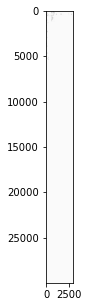

In [8]:
class DSBuilder(DatasetBuilder):
    def setUp(self, driver):
        """
            This method may be overwitten if you need to login to the site
            and navigate to a specific url,
            otherwise it just returns 
        """
        
        driver.set_window_size(width=1500, height=15000)
        self.driver.get(self.url)
        driver.find_element_by_id("user-icon").click()
        driver.find_element_by_id("name").send_keys(LOGIN)
        driver.find_element_by_id("password").send_keys(PASSWORD)
        driver.find_element_by_id("login-button").click()
        sleep(WAIT_TIME_SECONDS)
        driver.find_element_by_xpath("/html/body/div/div[1]/div/div[1]/div/div[1]/ul/li[5]/a/div").click() #path to elements packs
        driver.find_element_by_xpath("/html/body/div/div[1]/div/div[1]/div/div[1]/ul/li[5]/ul/li[8]/a").click() #path to mui
        driver.find_element_by_xpath("//*[@id='__next']/div/div/div[1]/div/div[6]").click() #path to checkboxes
        sleep(3.0)
        maximize_window(driver=driver, extend_pix=0)
        sleep(7.0)
        
with DSBuilder(url=SITE_URL, dataset_name=DATASET_NAME, headless=True, dataset_root_path=dataset_path) as builder:
    df = builder.dataset
    dataset_json = builder.dataset_json
    plt.figure(figsize = (20,5))
    plt.imshow(plt.imread(f'{dataset_path}/images/{DATASET_NAME}.png'))

In [9]:
%%time

response = requests.post(
    PREDICT_URL, data=json.dumps(dataset_json)
)

if response.status_code == 200:
    display(json.loads(response.text))
else:
    raise Exception(response.text)

[{'element_id': '0850210386193831087329397634',
  'x': 274.0,
  'y': 32.0,
  'width': 1202.0,
  'height': 539.171875,
  'predicted_label': 'stepper',
  'predicted_probability': 0.9847474694,
  'sort_key': 648084.59375},
 {'element_id': '0152281439193831081216949458',
  'x': 0.0,
  'y': 2448.0,
  'width': 250.0,
  'height': 48.0,
  'predicted_label': 'button',
  'predicted_probability': 1.0,
  'sort_key': 12000.0},
 {'element_id': '5088135805193831082606381203',
  'x': 0.0,
  'y': 1008.0,
  'width': 250.0,
  'height': 48.0,
  'predicted_label': 'button',
  'predicted_probability': 1.0,
  'sort_key': 12000.0},
 {'element_id': '6345689875193831085127877713',
  'x': 0.0,
  'y': 1152.0,
  'width': 250.0,
  'height': 48.0,
  'predicted_label': 'button',
  'predicted_probability': 1.0,
  'sort_key': 12000.0},
 {'element_id': '6110227692193831086205973991',
  'x': 0.0,
  'y': 2064.0,
  'width': 250.0,
  'height': 48.0,
  'predicted_label': 'button',
  'predicted_probability': 1.0,
  'sort_key'

CPU times: user 60.1 ms, sys: 18.4 ms, total: 78.5 ms
Wall time: 3.78 s


In [10]:
from utils.common import load_gray_image
from matplotlib.patches import Rectangle

In [11]:
df = pd.read_pickle(f'{dataset_path}/df/{DATASET_NAME}.pkl')[['element_id', 'tag_name']]
df['element_id'] = df['element_id'].astype(str)
preds = pd.DataFrame(json.loads(response.text))
preds['element_id'] = preds['element_id'].astype(str)
predictions_df = preds.merge(df, on='element_id')
predictions_df.head()

,element_id,x,y,width,height,predicted_label,predicted_probability,sort_key,tag_name
0,0850210386193831087329397634,274.0,32.0,1202.0,539.171875,stepper,0.984747,648084.59375,DIV
1,0152281439193831081216949458,0.0,2448.0,250.0,48.000000,button,1.000000,12000.00000,DIV
2,5088135805193831082606381203,0.0,1008.0,250.0,48.000000,button,1.000000,12000.00000,DIV
3,6345689875193831085127877713,0.0,1152.0,250.0,48.000000,button,1.000000,12000.00000,DIV
4,6110227692193831086205973991,0.0,2064.0,250.0,48.000000,button,1.000000,12000.00000,DIV


In [12]:
preds

,element_id,x,y,width,height,predicted_label,predicted_probability,sort_key
0,0850210386193831087329397634,274.000000,32.00000,1202.0,539.171875,stepper,0.984747,648084.59375
1,0152281439193831081216949458,0.000000,2448.00000,250.0,48.000000,button,1.000000,12000.00000
2,5088135805193831082606381203,0.000000,1008.00000,250.0,48.000000,button,1.000000,12000.00000
3,6345689875193831085127877713,0.000000,1152.00000,250.0,48.000000,button,1.000000,12000.00000
4,6110227692193831086205973991,0.000000,2064.00000,250.0,48.000000,button,1.000000,12000.00000
...,...,...,...,...,...,...,...,...
74,6970468040193831082922700445,362.828125,170.21875,223.0,32.000000,select,1.000000,7136.00000
75,3550502011193831086488753844,763.484375,170.21875,223.0,32.000000,select,1.000000,7136.00000
76,8794338084193831083533364275,938.484375,162.21875,48.0,48.000000,button,1.000000,2304.00000
77,5892016909193831088560206434,1339.140625,162.21875,48.0,48.000000,button,1.000000,2304.00000


In [13]:
from_pkl = pd.read_pickle(f'{dataset_path}/df/{DATASET_NAME}.pkl')
from_pkl[from_pkl.element_id == '1049561488694071642269580342']

,attributes,displayed,element_id,height,onmouseenter,onmouseover,parent_id,style,tag_name,text,width,x,y


<AxesSubplot:>

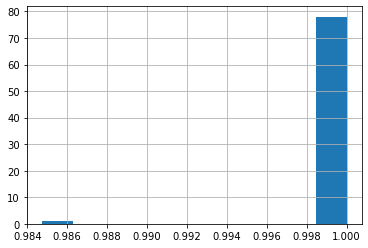

In [14]:
predictions_df['predicted_probability'].hist()

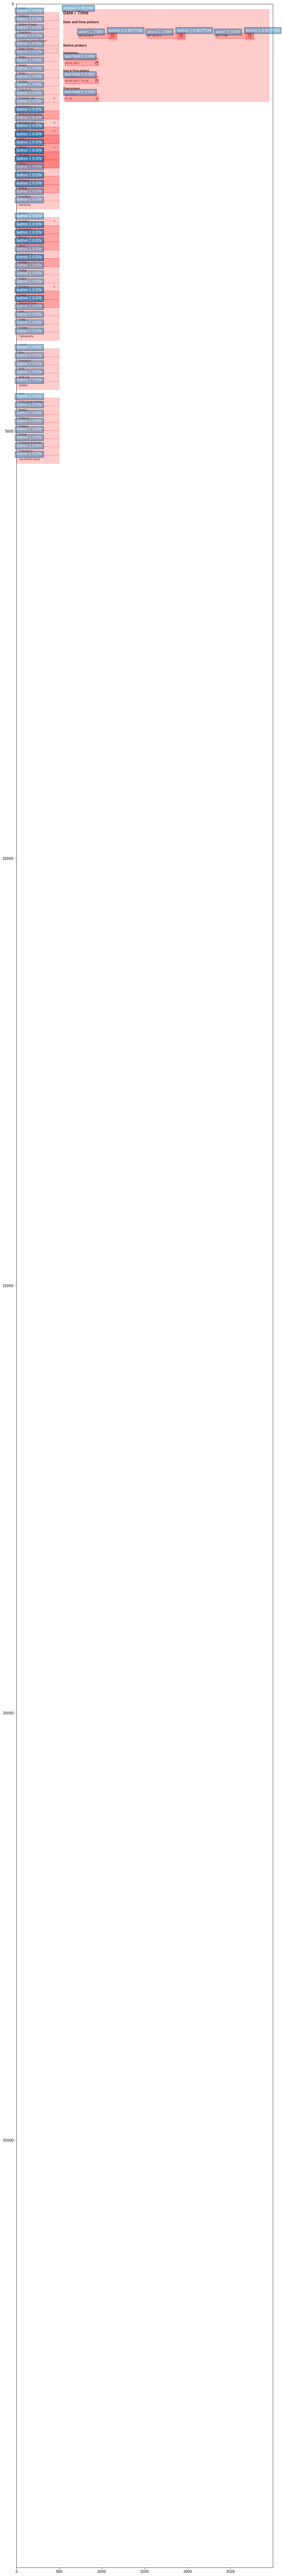

In [15]:
img = load_gray_image(f'{dataset_path}/images/{DATASET_NAME}.png')
plt.figure(figsize=(13,300))
plt.imshow(img, cmap='gray')

axes = plt.gca()

for _, r in predictions_df.iterrows():
    if r.predicted_probability > 0.0:
        patch = Rectangle((r.x*2, r.y*2), r.width*2, r.height*2, alpha=.2, color='red')
        axes.add_patch(patch)
        axes.text(r.x*2, r.y*2, 
                r.predicted_label + ':' +str(round(r.predicted_probability, 2)) + ':' + r.tag_name, 
                backgroundcolor='black', 
                color='white',
                bbox=dict(alpha=0.5))